<a href="https://colab.research.google.com/github/abhishek-parashar/neural-style-transfer/blob/master/neural_style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -q lucid>=0.2.3

In [0]:
%tensorflow_version 1.x
import tensorflow as tf


In [0]:
import numpy as np


from lucid.modelzoo import vision_models
from lucid.misc.io import show, load, save
from lucid.misc.tfutil import create_session

import lucid.optvis.objectives as objectives
import lucid.optvis.param as param
import lucid.optvis.render as render

In [0]:
from lucid.optvis.objectives import wrap_objective

In [6]:
model = vision_models.InceptionV1()
model.load_graphdef()

In [7]:
tf.test.is_gpu_available()

True

In [52]:
from PIL import Image
image=Image.open("manali.jpeg")
print(image.format)
profile1=image.resize((512,512))

JPEG


In [0]:
profile1.save('newprofile.jpg')

In [30]:
from PIL import Image
image=Image.open("mona-lisa.jpg")
print(image.format)
profile1=image.resize((645,512))
profile1.size

JPEG


(645, 512)

In [0]:
profile1.save('newmonalisa.jpg')

(512, 512, 3) (512, 645, 3)



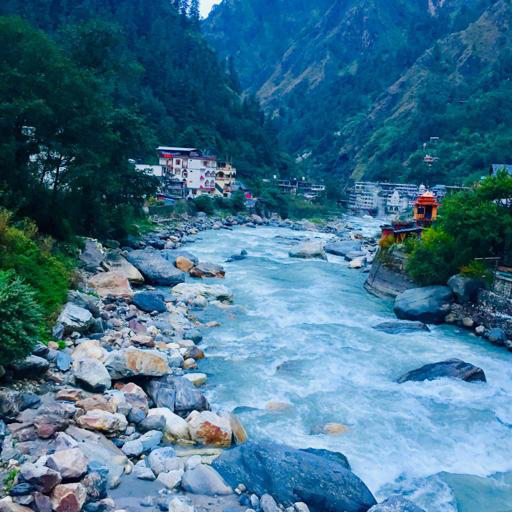


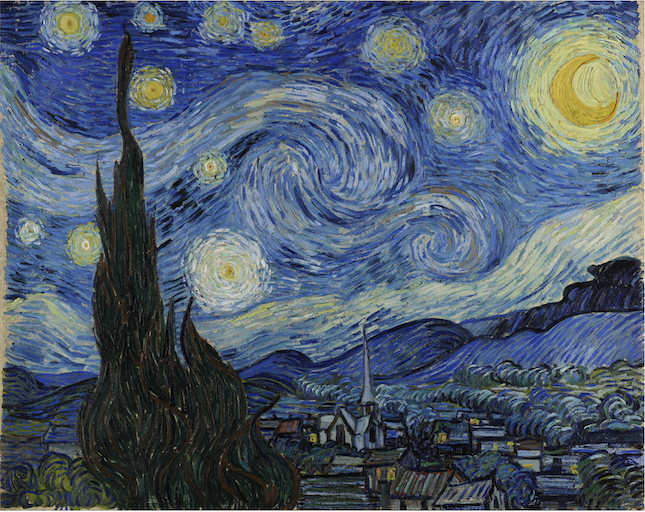

In [54]:
content_image = load("newprofile.jpg")
style_image = load("https://storage.googleapis.com/tensorflow-lucid/static/img/starry-night.png")[..., :3] # removes transparency channel

print(content_image.shape, style_image.shape)

show(content_image)
show(style_image)

In [0]:
style_layers = [
  'conv2d2',
  'mixed3a',
  'mixed4a',
  'mixed4b',
  'mixed4c',
]

content_layers = [
  'mixed3b',
]

In [0]:
def style_transfer_param(content_image, style_image, decorrelate=True, fft=True):
  style_transfer_input = param.image(*content_image.shape[:2], decorrelate=decorrelate, fft=fft)[0]
  content_input = content_image
  style_input = tf.random_crop(style_image, content_image.shape)
  return tf.stack([style_transfer_input, content_input, style_input])

# these constants help remember which image is at which batch dimension
TRANSFER_INDEX = 0
CONTENT_INDEX = 1
STYLE_INDEX = 2

In [57]:
style_transfer_param(content_image, style_image).shape

TensorShape([Dimension(3), Dimension(512), Dimension(512), Dimension(3)])

In [0]:
def mean_L1(a, b):
  return tf.reduce_mean(tf.abs(a-b))

In [0]:
@wrap_objective
def activation_difference(layer_names, activation_loss_f=mean_L1, transform_f=None, difference_to=CONTENT_INDEX):
  def inner(T):
    # first we collect the (constant) activations of image we're computing the difference to
    image_activations = [T(layer_name)[difference_to] for layer_name in layer_names]
    if transform_f is not None:
      image_activations = [transform_f(act) for act in image_activations]

    # we also set get the activations of the optimized image which will change during optimization
    optimization_activations = [T(layer)[TRANSFER_INDEX] for layer in layer_names]
    if transform_f is not None:
      optimization_activations = [transform_f(act) for act in optimization_activations]

    # we use the supplied loss function to compute the actual losses
    losses = [activation_loss_f(a, b) for a, b in zip(image_activations, optimization_activations)]
    return tf.add_n(losses)

  return inner

In [0]:
def gram_matrix(array, normalize_magnitue=True):
  channels = tf.shape(array)[-1]
  array_flat = tf.reshape(array, [-1, channels])
  gram_matrix = tf.matmul(array_flat, array_flat, transpose_a=True)
  if normalize_magnitue:
    length = tf.shape(array_flat)[0]
    gram_matrix /= tf.cast(length, tf.float32)
  return gram_matrix

In [0]:
param_f = lambda: style_transfer_param(content_image, style_image)

content_obj = 100 * activation_difference(content_layers, difference_to=CONTENT_INDEX)
content_obj.description = "Content Loss"

style_obj = activation_difference(style_layers, transform_f=gram_matrix, difference_to=STYLE_INDEX)
style_obj.description = "Style Loss"

objective = - content_obj - style_obj

vis = render.render_vis(model, objective, param_f=param_f, thresholds=[512], verbose=False, print_objectives=[content_obj, style_obj])[-1]


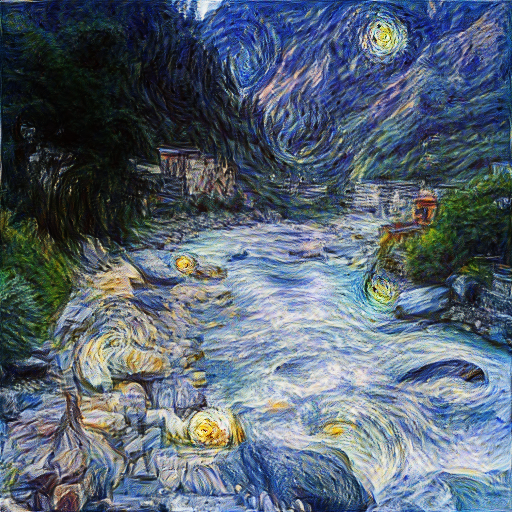
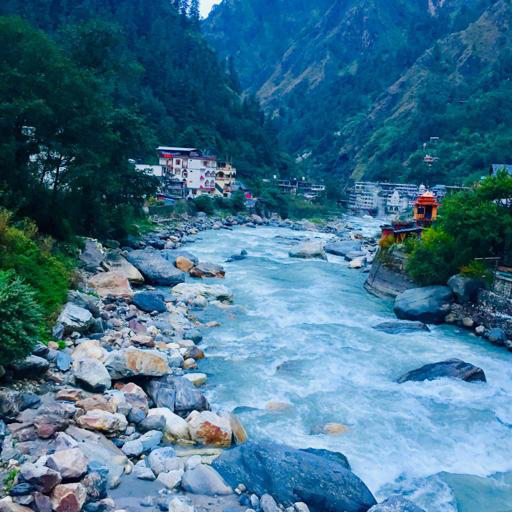
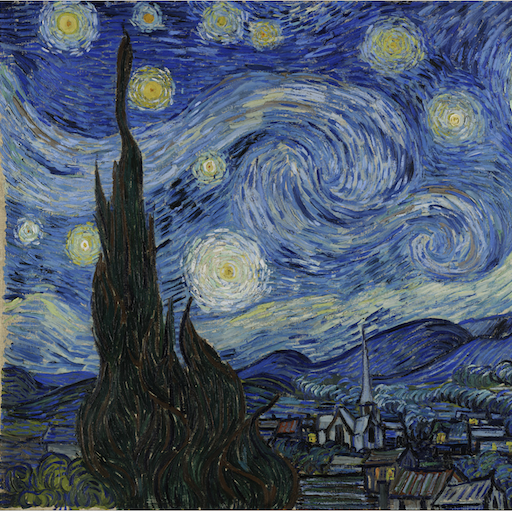

In [62]:
show(vis)

